[*********************100%***********************]  50 of 50 completed



Optimizing with alpha = 0.05

Training Period: 2015-01-01 to 2019-12-31
Optimization Successful
UPR on Training Data: 0.5522
UPR on Testing Data: 0.6504
VaR 95%: -0.0549
CVaR 95%: -0.0728

Training Period: 2016-01-01 to 2020-12-31
Optimization Successful
UPR on Training Data: 0.5372
UPR on Testing Data: 0.5873
VaR 95%: -0.0520
CVaR 95%: -0.0682

Training Period: 2017-01-01 to 2021-12-31
Optimization Successful
UPR on Training Data: 0.5460
UPR on Testing Data: 0.5800
VaR 95%: -0.0522
CVaR 95%: -0.0698

Training Period: 2018-01-01 to 2022-12-31
Optimization Successful
UPR on Training Data: 0.5211
UPR on Testing Data: 0.5823
VaR 95%: -0.0462
CVaR 95%: -0.0623

Training Period: 2019-01-01 to 2023-12-31
Optimization Successful
UPR on Training Data: 0.5553
UPR on Testing Data: 0.6310
VaR 95%: -0.0571
CVaR 95%: -0.0711

Optimizing with alpha = 0.1

Training Period: 2015-01-01 to 2019-12-31
Optimization Successful
UPR on Training Data: 0.5307
UPR on Testing Data: 0.6086
VaR 95%: -0.0440
CVaR 

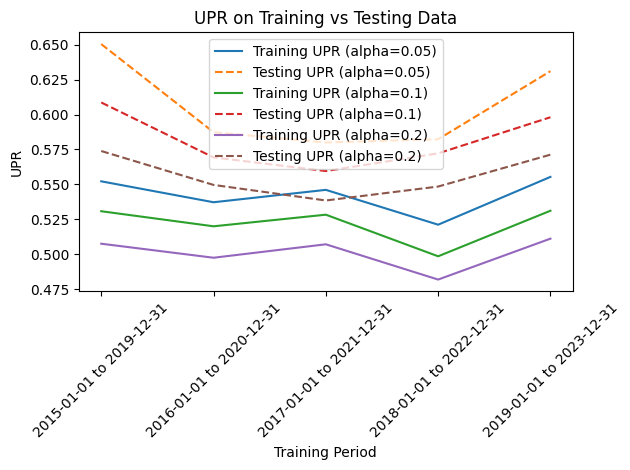

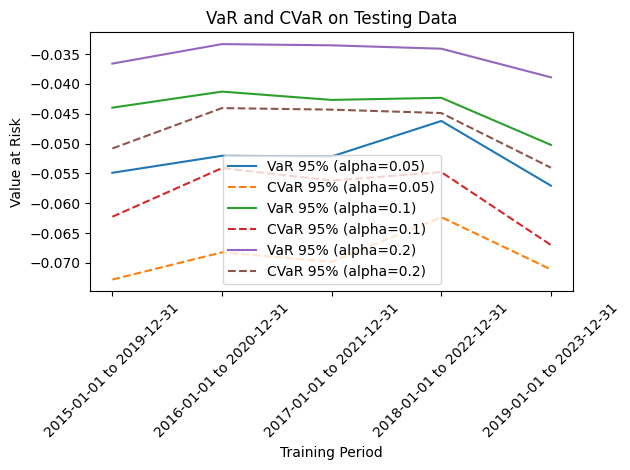

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import differential_evolution

# Step 1: Allow the user to input their Desired Target Return (DTR)
DTR = 0.002

# Step 2: Download historical price data
assets = [
    'AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'META', 'JPM', 'V', 'JNJ', 'WMT',
    'PG', 'DIS', 'NVDA', 'HD', 'MA', 'BAC', 'VZ', 'ADBE', 'NFLX', 'KO',
    'NKE', 'MRK', 'PFE', 'PEP', 'T', 'ABT', 'CVX', 'CSCO', 'ORCL', 'CMCSA',
    'INTC', 'CRM', 'COST', 'MDT', 'LLY', 'ACN', 'DHR', 'IBM', 'MCD', 'MMM',
    'UNH', 'HON', 'NEE', 'UNP', 'LIN', 'AMGN', 'TXN', 'C', 'AVGO', 'QCOM'
]

# Define the training and testing periods
train_periods = [
    ('2015-01-01', '2019-12-31'),
    ('2016-01-01', '2020-12-31'),
    ('2017-01-01', '2021-12-31'),
    ('2018-01-01', '2022-12-31'),
    ('2019-01-01', '2023-12-31')
]
test_start_date = '2024-01-01'
test_end_date = '2024-10-01'

# Download data
data = yf.download(assets, start='2015-01-01', end=test_end_date)['Adj Close']

# Number of assets
num_assets = len(assets)

# Function definitions
def portfolio_returns(weights, returns):
    return returns.dot(weights)

def downside_deviation(portfolio_returns, DTR):
    downside_diff = np.minimum(0, portfolio_returns - DTR)
    downside_risk = np.sqrt(np.mean(downside_diff**2))
    return downside_risk

def upside_potential(portfolio_returns, DTR):
    upside_diff = np.maximum(0, portfolio_returns - DTR)
    upside_potential = np.mean(upside_diff)
    return upside_potential

def UPR(weights, returns, DTR):
    port_returns = portfolio_returns(weights, returns)
    up_pot = upside_potential(port_returns, DTR)
    down_dev = downside_deviation(port_returns, DTR)
    if down_dev == 0:
        return np.inf
    else:
        return up_pot / down_dev

# Store results for comparison
results = []

# Alpha values for L2 regularization
alpha_values = [0.05, 0.1, 0.2]

for alpha in alpha_values:
    print(f"\nOptimizing with alpha = {alpha}")
    for train_start_date, train_end_date in train_periods:
        print(f"\nTraining Period: {train_start_date} to {train_end_date}")

        # Split data into training and testing sets
        train_data = data.loc[train_start_date:train_end_date]
        test_data = data.loc[test_start_date:test_end_date]

        # Calculate daily returns
        train_returns = train_data.pct_change().dropna()
        test_returns = test_data.pct_change().dropna()

        # Negative UPR function with L2 regularization
        def negative_UPR_with_regularization(weights, returns, DTR, alpha):
            upr = UPR(weights, returns, DTR)
            reg = alpha * np.sum(weights**2)
            return -upr + reg

        # Constraints: weights sum to 1, weights between 0 and 1
        bounds = [(0, 1) for _ in range(num_assets)]
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

        # Advanced Optimization Technique: Differential Evolution
        result = differential_evolution(
            negative_UPR_with_regularization,
            bounds=bounds,
            args=(train_returns, DTR, alpha),
            strategy='best1bin',
            maxiter=1000,
            popsize=15,
            tol=0.01,
            mutation=(0.5, 1),
            recombination=0.7,
            polish=True,
            disp=False
        )

        if result.success:
            optimal_weights = result.x
            print("Optimization Successful")

            # Evaluate performance on training and testing data
            optimal_portfolio_train_returns = portfolio_returns(optimal_weights, train_returns)

            # Align test returns with portfolio weights and ensure correct shape
            aligned_test_returns = test_returns[test_returns.columns.intersection(train_returns.columns)]

            # Shift returns to avoid look-ahead bias and match the number of assets
            shifted_test_returns = aligned_test_returns.shift(1).dropna()

            # Perform the dot product if shapes match
            if shifted_test_returns.shape[1] == len(optimal_weights):
                optimal_portfolio_test_returns = portfolio_returns(optimal_weights, shifted_test_returns)
            else:
                print(f"Shape mismatch: Test returns shape {shifted_test_returns.shape}, Weights shape {len(optimal_weights)}")
                continue

            # Calculate additional risk metrics
            VaR_95 = np.percentile(optimal_portfolio_test_returns, 5)
            CVaR_95 = optimal_portfolio_test_returns[optimal_portfolio_test_returns <= VaR_95].mean()

            # Store results
            results.append({
                'alpha': alpha,
                'train_period': f"{train_start_date} to {train_end_date}",
                'weights': optimal_weights,
                'UPR_train': UPR(optimal_weights, train_returns, DTR),
                'UPR_test': UPR(optimal_weights, shifted_test_returns, DTR),
                'VaR_95': VaR_95,
                'CVaR_95': CVaR_95
            })

            print(f"UPR on Training Data: {UPR(optimal_weights, train_returns, DTR):.4f}")
            print(f"UPR on Testing Data: {UPR(optimal_weights, shifted_test_returns, DTR):.4f}")
            print(f"VaR 95%: {VaR_95:.4f}")
            print(f"CVaR 95%: {CVaR_95:.4f}")
        else:
            print("Optimization failed")
            continue

# Analyze results
df_results = pd.DataFrame(results)
print(df_results)


# Display results
print("\nSummary of Results:")
print(df_results[['alpha', 'train_period', 'UPR_train', 'UPR_test', 'VaR_95', 'CVaR_95']])

# Plot UPR on Training vs Testing Data
for alpha in alpha_values:
    df_alpha = df_results[df_results['alpha'] == alpha]
    plt.plot(df_alpha['train_period'], df_alpha['UPR_train'], label=f'Training UPR (alpha={alpha})')
    plt.plot(df_alpha['train_period'], df_alpha['UPR_test'], label=f'Testing UPR (alpha={alpha})', linestyle='--')

plt.title('UPR on Training vs Testing Data')
plt.xlabel('Training Period')
plt.ylabel('UPR')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot VaR and CVaR
for alpha in alpha_values:
    df_alpha = df_results[df_results['alpha'] == alpha]
    plt.plot(df_alpha['train_period'], df_alpha['VaR_95'], label=f'VaR 95% (alpha={alpha})')
    plt.plot(df_alpha['train_period'], df_alpha['CVaR_95'], label=f'CVaR 95% (alpha={alpha})', linestyle='--')

plt.title('VaR and CVaR on Testing Data')
plt.xlabel('Training Period')
plt.ylabel('Value at Risk')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


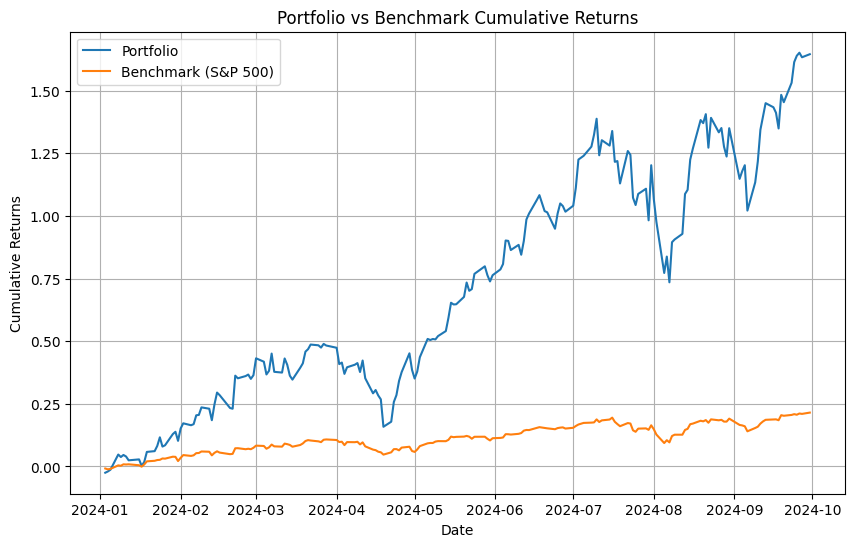

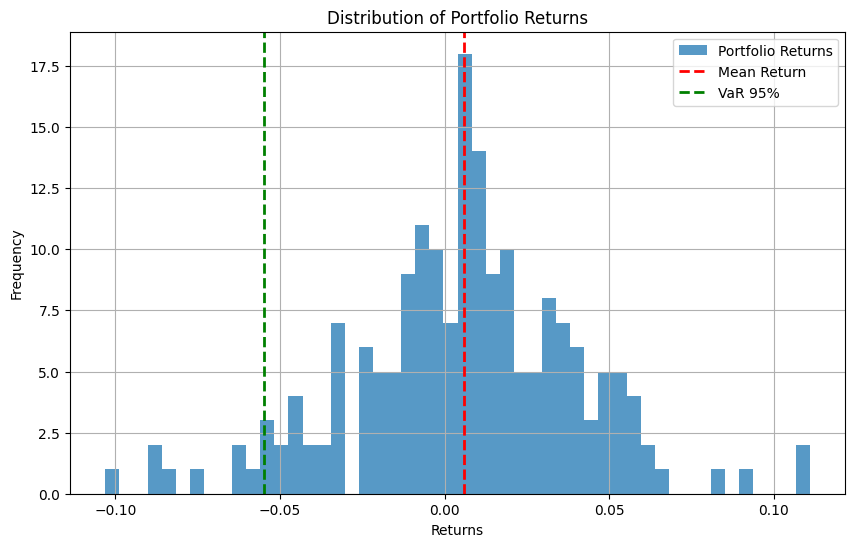

In [9]:

# Download benchmark data (S&P 500 Index)
benchmark_data = yf.download('^GSPC', start='2024-01-01', end=test_end_date)['Adj Close']
benchmark_returns = benchmark_data.pct_change().dropna()

# Find the portfolio with the best UPR
best_portfolio = df_results.loc[df_results['UPR_test'].idxmax()]

# Extract the weights and corresponding test period returns
optimal_weights = best_portfolio['weights']
test_start_date = '2024-01-01'
test_end_date = '2024-10-01'
test_data = data.loc[test_start_date:test_end_date]
test_returns = test_data.pct_change().dropna()

# Portfolio returns (based on best portfolio weights)
portfolio_returns = test_returns.dot(optimal_weights)

# Cumulative returns for portfolio and benchmark
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
cumulative_benchmark_returns = (1 + benchmark_returns).cumprod() - 1

# Plot portfolio vs benchmark returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns, label='Portfolio')
plt.plot(cumulative_benchmark_returns, label='Benchmark (S&P 500)')
plt.title('Portfolio vs Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of portfolio returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.75, label='Portfolio Returns')
plt.axvline(np.mean(portfolio_returns), color='r', linestyle='dashed', linewidth=2, label='Mean Return')
plt.axvline(np.percentile(portfolio_returns, 5), color='g', linestyle='dashed', linewidth=2, label='VaR 95%')
plt.title('Distribution of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Calculate and plot common performance metrics
sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns) * np.sqrt(252)  # Annualized Sharpe ratio
sortino_ratio = np.mean(portfolio_returns) / downside_deviation(portfolio_returns, DTR)  # Sortino ratio
max_drawdown = np.min(cumulative_portfolio_returns - cumulative_portfolio_returns.cummax())  # Max Drawdown

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

Sharpe Ratio: 2.67
Sortino Ratio: 0.25
Max Drawdown: -65.28%


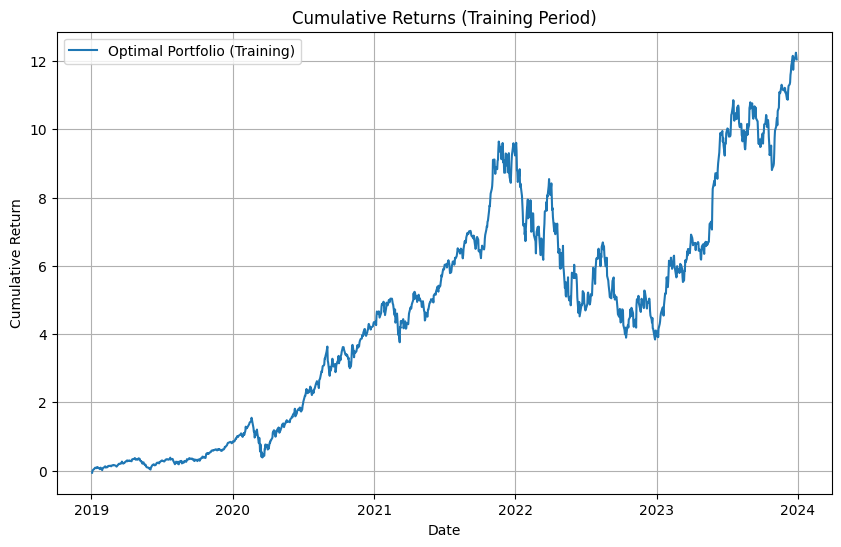

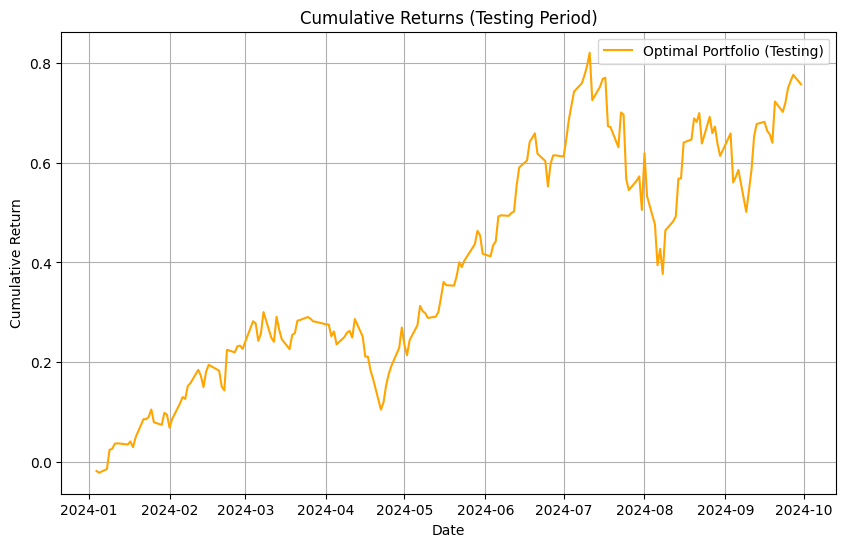

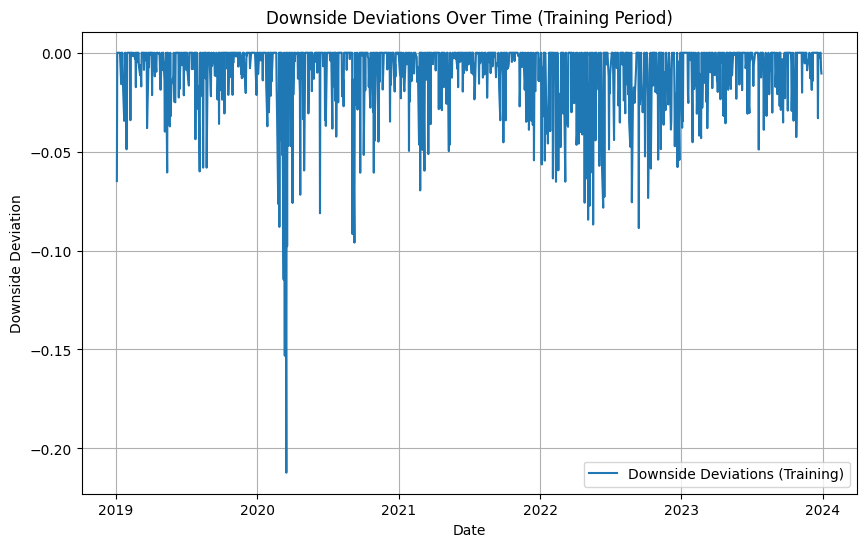

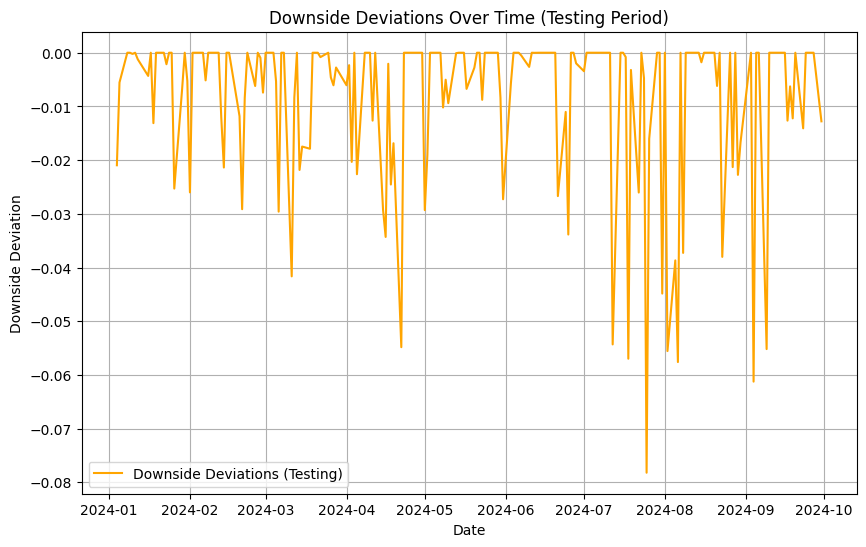

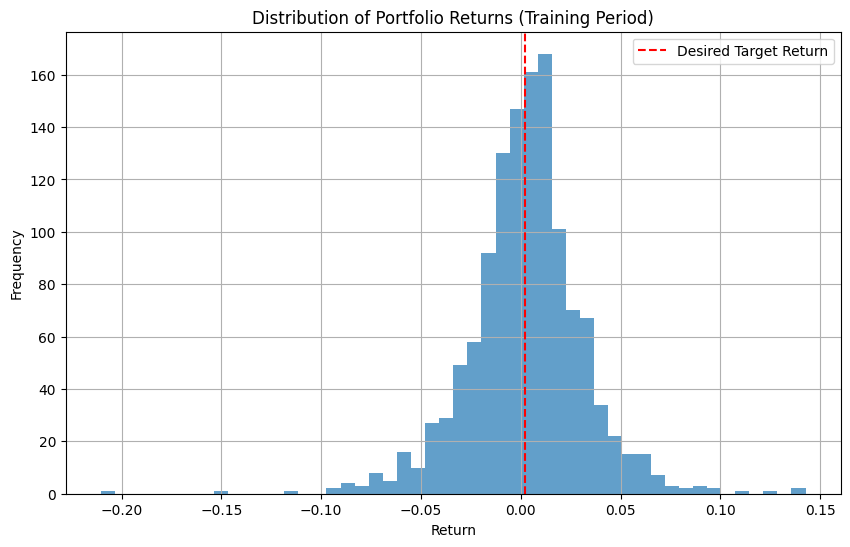

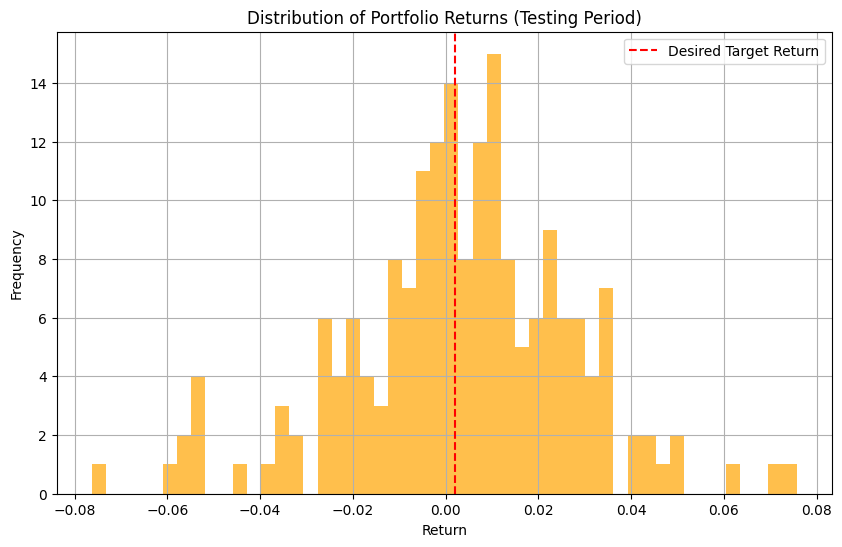

In [11]:
# Plot cumulative returns on training data
cumulative_train_returns = (1 + optimal_portfolio_train_returns).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(cumulative_train_returns, label='Optimal Portfolio (Training)')
plt.title('Cumulative Returns (Training Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative returns on testing data
cumulative_test_returns = (1 + optimal_portfolio_test_returns).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(cumulative_test_returns, label='Optimal Portfolio (Testing)', color='orange')
plt.title('Cumulative Returns (Testing Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot downside deviations over time on training data
downside_diff_train = np.minimum(0, optimal_portfolio_train_returns - DTR)
plt.figure(figsize=(10, 6))
plt.plot(downside_diff_train, label='Downside Deviations (Training)')
plt.title('Downside Deviations Over Time (Training Period)')
plt.xlabel('Date')
plt.ylabel('Downside Deviation')
plt.legend()
plt.grid(True)
plt.show()

# Plot downside deviations over time on testing data
downside_diff_test = np.minimum(0, optimal_portfolio_test_returns - DTR)
plt.figure(figsize=(10, 6))
plt.plot(downside_diff_test, label='Downside Deviations (Testing)', color='orange')
plt.title('Downside Deviations Over Time (Testing Period)')
plt.xlabel('Date')
plt.ylabel('Downside Deviation')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of portfolio returns on training data
plt.figure(figsize=(10, 6))
plt.hist(optimal_portfolio_train_returns, bins=50, alpha=0.7)
plt.axvline(DTR, color='r', linestyle='--', label='Desired Target Return')
plt.title('Distribution of Portfolio Returns (Training Period)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of portfolio returns on testing data
plt.figure(figsize=(10, 6))
plt.hist(optimal_portfolio_test_returns, bins=50, alpha=0.7, color='orange')
plt.axvline(DTR, color='r', linestyle='--', label='Desired Target Return')
plt.title('Distribution of Portfolio Returns (Testing Period)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import quantstats as qs

# Step 1: Define the optimal portfolio returns and benchmark returns
# Assuming optimal_portfolio_test_returns are already calculated
# Download benchmark data (S&P 500) for the same testing period
benchmark_data = yf.download('^GSPC', start=test_start_date, end=test_end_date)['Adj Close']
benchmark_returns = benchmark_data.pct_change().dropna()

# Step 2: Convert both returns to the same datetime format
# Convert both the index of portfolio and benchmark to remove timezone (UTC)
optimal_portfolio_test_returns.index = optimal_portfolio_test_returns.index.tz_localize(None)
benchmark_returns.index = benchmark_returns.index.tz_localize(None)

# Step 3: Generate the QuantStats HTML report comparing the portfolio with the benchmark
qs.reports.html(
    optimal_portfolio_test_returns,  # The portfolio returns
    benchmark=benchmark_returns,     # The benchmark returns (S&P 500)
    title="Optimal Portfolio vs S&P 500 Benchmark",  # Custom title for the report
    output='../reports/04 - sortino_framework_portfolio_construction.html'  # Output file name
)

print("QuantStats report generated: '04 - sortino_framework_portfolio_construction.html'")


[*********************100%***********************]  1 of 1 completed
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with a

QuantStats report generated: 'quantstats_report.html'


C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
C:\Users\sandr\Documents\GitHub\portfolio_s